<a href="https://colab.research.google.com/github/barani-bhoopalan/ML-model--to-classify-Diabetes--Logistic-Classifier/blob/master/ML_project_Logistic_Classifier_to_predict_Diabetes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##End-2-End Machine Learning- Logistic Regression

In [0]:
#import all of the libraries that we'll need for this lab
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn.metrics as sklm
import seaborn as sn
import warnings
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

#supress annoying deprecation warnings
warnings.filterwarnings('ignore')

#use the Iron Python "magic function" that will allow charts to be displayed inline in the Jupyter notebook
%matplotlib inline

In [53]:
##Read local file from google colab - upload file to google colab and it is stored in key
from google.colab import files 
uploaded = files.upload()

KeyboardInterrupt: ignored

In [54]:
##Print the list of files uploaded
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

User uploaded file "Lab Assignment 01 - Data.csv" with length 791427 bytes


In [0]:
#Load the diabetes data into a pandas dataframe named "df".
#"Patient_ID" is an attribute in the dataset whose values uniquely identify a woman. The "index_col" parameter
#tells Pandas to use Patient_ID as the index column in the dataframe. The index column serves the same purpose
#in a dataframe as a primary key in a relational database table.
import io
df = pd.read_csv(io.StringIO(uploaded['Lab Assignment 01 - Data.csv'].decode('utf-8')),  index_col='Patient_ID')

#### A. Preview Data

In [57]:
#display the first 5 rows of data in the dataframe
df.head()

,Pregnancies,Plasma_Glucose,Diastolic_Blood_Pressure,Triceps_Thickness,Serum_Insulin,BMI,Diabetes_Pedigree,Age,Has_Diabetes
Patient_ID,,,,,,,,,
1354778,0,171,80,34,23,43.509726,1.213191,21,0
1147438,8,92,93,47,36,21.240576,0.158365,23,0
1640031,7,115,47,52,35,41.511523,0.079019,23,0
1883350,9,103,78,25,304,29.582192,1.282870,43,1
1424119,1,85,59,27,35,42.604536,0.549542,22,0


#### B. Generate Descriptive Statistics

In [58]:
#display descriptive statistics for all of the variables in the dataframe
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Pregnancies,15000.0,3.224533,3.391020,0.000000,0.000000,2.000000,6.000000,14.000000
Plasma_Glucose,15000.0,107.856867,31.981975,44.000000,84.000000,104.000000,129.000000,192.000000
Diastolic_Blood_Pressure,15000.0,71.220667,16.758716,24.000000,58.000000,72.000000,85.000000,117.000000
Triceps_Thickness,15000.0,28.814000,14.555716,7.000000,15.000000,31.000000,41.000000,93.000000
Serum_Insulin,15000.0,137.852133,133.068252,14.000000,39.000000,83.000000,195.000000,799.000000
BMI,15000.0,31.509646,9.759000,18.200512,21.259887,31.767940,39.259692,56.034628
Diabetes_Pedigree,15000.0,0.398968,0.377944,0.078044,0.137743,0.200297,0.616285,2.301594
Age,15000.0,30.137733,12.089703,21.000000,22.000000,24.000000,35.000000,77.000000
Has_Diabetes,15000.0,0.333333,0.471420,0.000000,0.000000,0.000000,1.000000,1.000000


#### C. Visualize distribution of variable

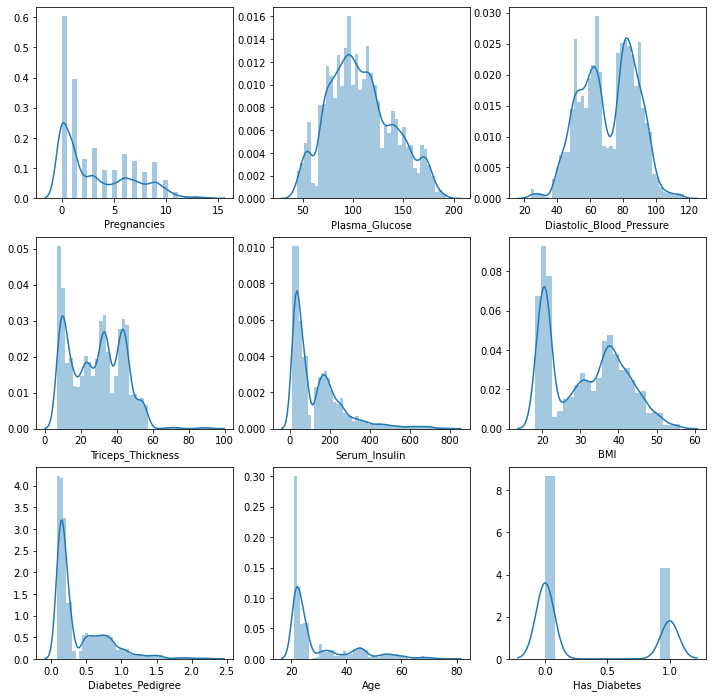

In [59]:
fig = plt.figure(figsize=(12,12))

for i in range(len(df.columns)):
  fig.add_subplot(3,3,i+1)
  sn.distplot(df.iloc[:,i].dropna())
  plt.xlabel(df.columns[i])

#### D. Study the Outliers

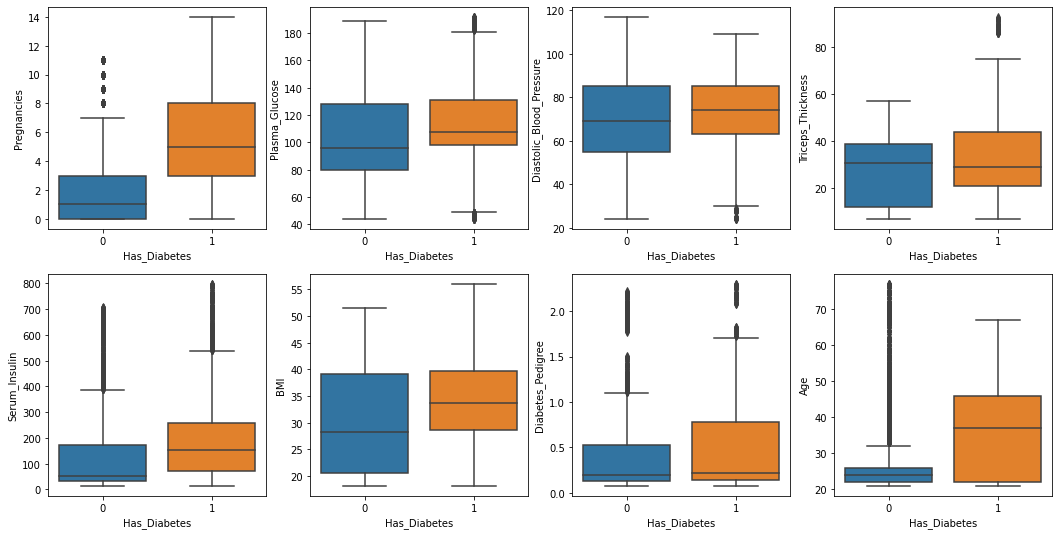

In [60]:
fig = plt.figure(figsize=(18,9))

for i in range(len(df.columns)-1):
  fig.add_subplot(2,4,i+1)
  sn.boxplot(x="Has_Diabetes", y=df.iloc[:,i].dropna(), data=df)

#### E. Correlations among variables

In [61]:
corr = df.corr(method='pearson')
corr

,Pregnancies,Plasma_Glucose,Diastolic_Blood_Pressure,Triceps_Thickness,Serum_Insulin,BMI,Diabetes_Pedigree,Age,Has_Diabetes
Pregnancies,1.000000,0.054502,0.043528,0.063605,0.104487,0.086386,0.054240,0.136972,0.407315
Plasma_Glucose,0.054502,1.000000,0.007212,0.027100,0.033545,0.020653,0.009057,0.038864,0.128004
Diastolic_Blood_Pressure,0.043528,0.007212,1.000000,0.011106,0.022649,0.015873,0.014099,0.041333,0.091307
Triceps_Thickness,0.063605,0.027100,0.011106,1.000000,0.029688,0.024745,-0.000951,0.061383,0.152505
Serum_Insulin,0.104487,0.033545,0.022649,0.029688,1.000000,0.051223,0.046324,0.088007,0.247375
BMI,0.086386,0.020653,0.015873,0.024745,0.051223,1.000000,0.028868,0.062910,0.210508
Diabetes_Pedigree,0.054240,0.009057,0.014099,-0.000951,0.046324,0.028868,1.000000,0.055633,0.170302
Age,0.136972,0.038864,0.041333,0.061383,0.088007,0.062910,0.055633,1.000000,0.342605
Has_Diabetes,0.407315,0.128004,0.091307,0.152505,0.247375,0.210508,0.170302,0.342605,1.000000


In [62]:
##From these values, we can see that Pregnancies and Age have the most impact on Has_Diabetes,

corr['Has_Diabetes'].sort_values(ascending=False)

Has_Diabetes                1.000000
Pregnancies                 0.407315
Age                         0.342605
Serum_Insulin               0.247375
BMI                         0.210508
Diabetes_Pedigree           0.170302
Triceps_Thickness           0.152505
Plasma_Glucose              0.128004
Diastolic_Blood_Pressure    0.091307
Name: Has_Diabetes, dtype: float64

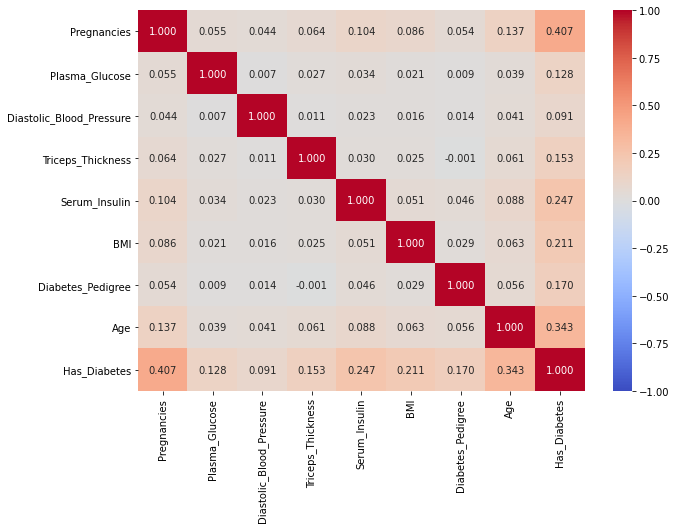

In [63]:
#draw a correlation matrix heatmap
fig, ax = plt.subplots(figsize=(10,7))
sn.heatmap(df.corr(), annot=True, fmt='.3f', vmin=-1, vmax=1, center=0, cmap='coolwarm', ax=ax)

#### F. Transfer Skewed Variable

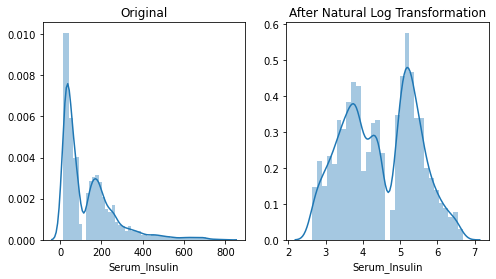

In [64]:
#apply natural log transformations to skewed variables
df['Pregnancies'] = np.log1p(df['Pregnancies'])
serum_insulin_original = df['Serum_Insulin'].copy() #save a copy of the original (untransformed) serum insulin levels
df['BMI'] = np.log(df['BMI'])
df['Diabetes_Pedigree'] = np.log(df['Diabetes_Pedigree'])
df['Age'] = np.log(df['Age'])

#plot the untransformed and transformed distributions for the "Serum_Insulin" variable
fig, ax = plt.subplots(1, 2, figsize=(8,4))
sn.distplot(serum_insulin_original, ax=ax[0])
sn.distplot(np.log(df['Serum_Insulin']), ax=ax[1])
ax[0].title.set_text('Original')
ax[1].title.set_text('After Natural Log Transformation')

#### G. Rescale Predictor Variables

In [0]:
#define a min-max scaler, and rescale all predictor variables to the range 0 to 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
predictors = ['Pregnancies', 'Plasma_Glucose', 'Diastolic_Blood_Pressure', 'Triceps_Thickness', 'Serum_Insulin', 'BMI', 'Diabetes_Pedigree', 'Age']
df[predictors] = scaler.fit_transform(df[predictors])

In [66]:
#show descriptive statistics for all of the rescaled predictor variables.
round(df[predictors].describe(),3).transpose()

,count,mean,std,min,25%,50%,75%,max
Pregnancies,15000.0,0.400,0.322,0.0,0.000,0.406,0.719,1.0
Plasma_Glucose,15000.0,0.431,0.216,0.0,0.270,0.405,0.574,1.0
Diastolic_Blood_Pressure,15000.0,0.508,0.180,0.0,0.366,0.516,0.656,1.0
Triceps_Thickness,15000.0,0.254,0.169,0.0,0.093,0.279,0.395,1.0
Serum_Insulin,15000.0,0.158,0.170,0.0,0.032,0.088,0.231,1.0
BMI,15000.0,0.444,0.284,0.0,0.138,0.495,0.684,1.0
Diabetes_Pedigree,15000.0,0.369,0.251,0.0,0.168,0.279,0.611,1.0
Age,15000.0,0.229,0.261,0.0,0.036,0.103,0.393,1.0


#### H. Split into Train and Test Data

In [0]:
#split the data into training and testing sets
df_train, df_test = train_test_split(df, train_size=0.7, shuffle=True, random_state=42)

#### I. Logistic Regression Model 

In [68]:
#train a logistic regression classifier
model = LogisticRegression(random_state=42)
model.fit(df_train[predictors], df_train['Has_Diabetes'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

##### i - Predict the model in test data

In [69]:
#generate predictions, and save them in a new column named "Has_Diabetes_Predicted" in the testing dataframe
df_test['Has_Diabetes_Predicted'] = model.predict(df_test[predictors])

#view actual and predicted values for the first 20 women in the testing set
df_test[['Has_Diabetes', 'Has_Diabetes_Predicted']].head(20)

,Has_Diabetes,Has_Diabetes_Predicted
Patient_ID,,
1763065,0,0
1814475,1,0
1473525,0,0
1123081,0,0
1479105,0,0
1978830,0,0
1689235,1,1
1936277,0,0
1924402,0,1


##### ii - Confusion Matrix

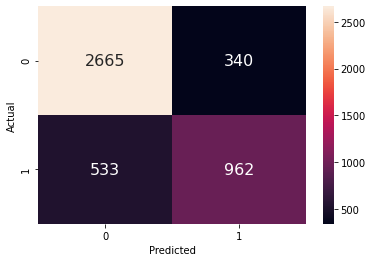

In [70]:
confusion_matrix = pd.crosstab(df_test['Has_Diabetes'], df_test['Has_Diabetes_Predicted'], rownames=['Actual'], colnames=['Predicted'])

ax= sn.heatmap(confusion_matrix, annot=True, annot_kws={"size": 16},fmt="d")
ax.set_ylim([2,0])
plt.show()


##### iii - Accuracy Stats

In [71]:
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 

print ('Accuracy Score :', round(accuracy_score(df_test['Has_Diabetes'], df_test['Has_Diabetes_Predicted']),3))
print ('Report : ')
print (classification_report(df_test['Has_Diabetes'], df_test['Has_Diabetes_Predicted']) )


Accuracy Score : 0.806
Report : 
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      3005
           1       0.74      0.64      0.69      1495

    accuracy                           0.81      4500
   macro avg       0.79      0.77      0.77      4500
weighted avg       0.80      0.81      0.80      4500



##### iv - ROC Curve

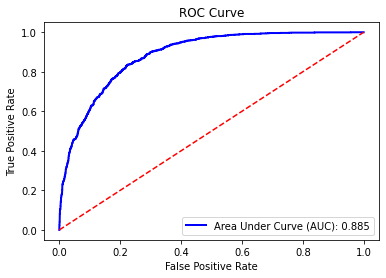

In [72]:
#define a function that generates a ROC curve
def generate_ROC_curve(actual, predicted_probabilities):
    fpr, tpr, _ = sklm.roc_curve(actual, predicted_probabilities)
    auc = sklm.roc_auc_score(actual, predicted_probabilities)
    plt.plot(fpr, tpr, 'b-', lw=2, label='Area Under Curve (AUC): {0:.3f}'.format(auc))
    plt.plot([0, 1], [0, 1], 'r--')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc=4)
    plt.show()

#compute predicted probabilities that each woman in the testing set has diabetes
predicted_probabilities = model.predict_proba(df_test[predictors])[::,1]

#generate a ROC curve for the logistic regression classifier
generate_ROC_curve(df_test['Has_Diabetes'], predicted_probabilities)

#### J. Gradient Boosting Classifier Model 

In [73]:
#train a gradient boosting classifier
model = GradientBoostingClassifier(learning_rate=0.5, random_state=42)
model.fit(df_train[predictors], df_train['Has_Diabetes'])


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

##### i - Predict the model in test data

In [74]:

#evaluate the performance of the gradient boosting classifier using the test set
df_test['Has_Diabetes_Predicted'] = model.predict(df_test[predictors])

#view actual and predicted values for the first 20 women in the testing set
df_test[['Has_Diabetes', 'Has_Diabetes_Predicted']].head(20)

,Has_Diabetes,Has_Diabetes_Predicted
Patient_ID,,
1763065,0,0
1814475,1,1
1473525,0,0
1123081,0,1
1479105,0,0
1978830,0,0
1689235,1,1
1936277,0,0
1924402,0,0


##### ii - Confusion Matrix

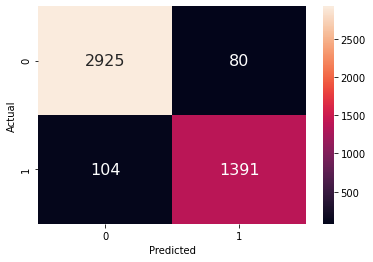

In [75]:
confusion_matrix = pd.crosstab(df_test['Has_Diabetes'], df_test['Has_Diabetes_Predicted'], rownames=['Actual'], colnames=['Predicted'])

ax= sn.heatmap(confusion_matrix, annot=True, annot_kws={"size": 16},fmt="d")
ax.set_ylim([2,0])
plt.show()

##### iii - Accuracy Stats

In [76]:
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 

print ('Accuracy Score :', round(accuracy_score(df_test['Has_Diabetes'], df_test['Has_Diabetes_Predicted']),3))
print ('Report : ')
print (classification_report(df_test['Has_Diabetes'], df_test['Has_Diabetes_Predicted']) )

Accuracy Score : 0.959
Report : 
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      3005
           1       0.95      0.93      0.94      1495

    accuracy                           0.96      4500
   macro avg       0.96      0.95      0.95      4500
weighted avg       0.96      0.96      0.96      4500



##### iv - ROC Curve

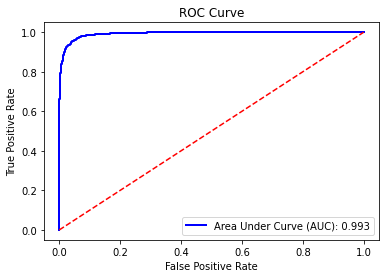

In [77]:
#compute predicted probabilities that each woman in the testing set has diabetes
predicted_probabilities = model.predict_proba(df_test[predictors])[::,1]

#generate a ROC curve for the gradient boosting classifier
generate_ROC_curve(df_test['Has_Diabetes'], predicted_probabilities)

The ROC curve for the gradient boosting classifier is much closer to the upper-left corner of the diagram than the logistic regression classifier, and the area under the gradient boosting classifier's ROC curve is also much larger that that of the logistic regression classifier. We can therefore conclude that the gradient boosting classifier is much better at predicting whether a woman has diabetes than the logistic regression model, at least among women who belong to the Pima people.